In [1]:
import sys
sys.argv=['main.ipynb', '--config', 'configs/cifar_Fedavg.yaml','--data', './data','--federated_iid','--federated_skew1class','--federated_dirichlet','--dirichlet_alpha','0.6','--batch_size','50',"--centralized_epochs",'150',"--global_epochs",'3','--alpha','0.5','--epsilon','0.1','--momentum','0.0','--lr','0.1','--learning_rate_decay','0.5','--weight_decay','1e-4','--seed','2021','--set','CIFAR10','--arch','Conv2','--workers','8']

In [2]:
from args import args

=> Reading YAML config from configs/cifar_Fedavg.yaml


In [3]:
%tb

No traceback available to show.


In [4]:
args

Namespace(alpha=0.5, alpha_divide_epoch=False, alpha_mul_epoch=False, arch='Conv2', batch_size=50, centralized=False, centralized_epochs=150, client_data='./client_data', config='configs/cifar_Fedavg.yaml', create_client_dataset=False, cuda_visible_device=0, data='./data', dirichlet_alpha=0.6, epsilon=0.1, federated_dirichlet=True, federated_iid=True, federated_skew1class=True, global_epochs=3, learning_rate_decay=0.5, local_epochs=5, log_dir=None, lr=0.1, momentum=0.0, num_classes=10, num_of_clients=100, optimizer='sgd', participation_rate=0.1, print_freq=1, seed=2021, set='CIFAR10', weight_decay=0.0001, workers=8)

In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   

os.environ["CUDA_VISIBLE_DEVICES"]=str(args.cuda_visible_device)

import matplotlib.pyplot as plt
import torch.optim as optim
import random
import models
import json

In [6]:
random_seed=args.seed
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
if args.set=='CIFAR10':
    
    
    
    transform = transforms.Compose(
        [
         transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
         transforms.RandomCrop(32, padding=4),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])    
    
    trainset = torchvision.datasets.CIFAR10(root=args.data, train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                              shuffle=True, num_workers=args.workers)

    testset = torchvision.datasets.CIFAR10(root=args.data, train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                             shuffle=False, num_workers=args.workers)
elif args.set=='MNIST':
    #!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
    #!tar -zxvf MNIST.tar.gz

    transform = transforms.Compose(
        [
         #transforms.RandomHorizontalFlip(),
         #transforms.RandomVerticalFlip(),
         #transforms.RandomCrop(28, padding=4),
         transforms.ToTensor(),
         transforms.Normalize((0.1307,), (0.3081,))
         ])   
    trainset = datasets.MNIST(root=args.data, train=True,
                                            download=True,
                                   transform=transform)
    
    trainloader=torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                              shuffle=True, num_workers=args.workers)    
    testset=datasets.MNIST(root=args.data, train=False,
                                           download=True,
                                   transform=transform)

    testloader=torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                              shuffle=True, num_workers=args.workers)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg)
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(npimg))#, (1, 2, 0)))
    plt.show()

In [11]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [12]:
def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    #num_items=8
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [13]:
def cifar_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    #num_shards, num_imgs = 200, 250
    #num_shards, num_imgs = 200, 250
    class_per_user=1
    num_shards=num_users*class_per_user
    num_imgs=int(len(dataset)/num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([],dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    #labels = np.array(dataset.train_labels)

    labels=[]
    for element in dataset:
        labels.append(int(element[1]))
    #print(type(labels[0]))
    labels=np.array(labels)
    #labels=labels.astype('int64')
    # sort labels
    
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, class_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = set(np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0))
    return dict_users

In [14]:
def cifar_dirichlet(dataset, n_nets, alpha=0.5):
    '''
    if dataset == 'mnist':
        X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    elif dataset == 'cifar10':
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    '''
    #X_train=dataset[:][0]
    y_train=torch.zeros(len(dataset),dtype=torch.long)
    print(y_train.dtype)
    for a in range(len(dataset)):
        y_train[a]=(dataset[a][1])
    n_train = len(dataset)
    #X_train.shape[0]
    '''
    if partition == "homo":
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_nets)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_nets)}
    '''
    #elif partition == "hetero-dir":
    min_size = 0
    K = 10
    N=len(dataset)
    N = y_train.shape[0]
    net_dataidx_map = {i: np.array([],dtype='int64') for i in range(n_nets)}

    while min_size < 10:
        idx_batch = [[] for _ in range(n_nets)]
        for k in range(K):
            idx_k = np.where(y_train == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, n_nets))
            ## Balance
            proportions = np.array([p*(len(idx_j)<N/n_nets) for p,idx_j in zip(proportions,idx_batch)])
            proportions = proportions/proportions.sum()
            proportions = (np.cumsum(proportions)*len(idx_k)).astype(int)[:-1]
            idx_batch = [idx_j + idx.tolist() for idx_j,idx in zip(idx_batch,np.split(idx_k,proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

        for j in range(n_nets):
            np.random.shuffle(idx_batch[j])
            net_dataidx_map[j] = idx_batch[j]

    #traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    return net_dataidx_map
    #return (X_train, y_train, X_test, y_test, net_dataidx_map, traindata_cls_counts)

In [15]:
def get_model(args):

    print("=> Creating model '{}'".format(args.arch))
    model = models.__dict__[args.arch]()
    return model

In [16]:
def get_optimizer():
    if args.set=='CIFAR10':
        optimizer = optim.SGD(net.parameters(), lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
    elif args.set=="MNIST":
        optimizer = optim.SGD(net.parameters(), lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
    else:
        print("Invalid mode")
        return
    return optimizer

In [17]:
def get_scheduler(optimizer):
    if args.set=='CIFAR10':
        scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: args.learning_rate_decay ** epoch,
                                )
    elif args.set=="MNIST":
        scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: args.learning_rate_decay ** (int(epoch/50)),
                                )
    else:
        print("Invalid mode")
        return
    return scheduler

In [18]:
if args.centralized==True:
    net = get_model(args)
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer()
    scheduler = get_scheduler(optimizer)
    loss_train = []
    acc_train=[]

In [19]:
if args.centralized==True:
    for epoch in range(args.centralized_epochs):   # 데이터셋을 수차례 반복합니다.

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
            inputs, labels = data[0].to(device), data[1].to(device)
            #print(labels)

            # 변화도(Gradient) 매개변수를 0으로 만들고
            optimizer.zero_grad()

            # 순전파 + 역전파 + 최적화를 한 후
            outputs = net(inputs)
            #print(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            


        if epoch%args.print_freq==0:
            loss_train.append(loss)
            print(f"epoch: {epoch}")
            print(' Average loss {:.3f}'.format( loss))
            for j in range(1):
                net.eval()         
                correct = 0
                total = 0
                with torch.no_grad():
                    for data in testloader:
                        images, labels = data[0].to(device), data[1].to(device)
                        outputs = net(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                print('Accuracy of the network on the 10000 test images: %f %%' % (
                    100 * correct / total))
            acc_train.append(100 * correct / total)

            net.train()
        scheduler.step()
            


In [20]:
if args.centralized==True:
    fig,ax1=plt.subplots()
    ax2=ax1.twinx()
    line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
    line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
    lines=line1+line2
    ax1.set_ylabel("loss")
    ax2.set_ylabel("accuracy")
    plt.xlabel('Epoch')
    plt.title('Experiment Result')
    plt.legend(lines,['loss_train','acc_train'])
    plt.show()

In [21]:
if args.centralized==True:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * correct / total))


In [22]:
class LocalUpdate(object):
    def __init__(self, lr,local_epoch,device,batch_size, dataset=None, idxs=None,alpha=0.0001):
        self.lr=lr
        self.local_epoch=local_epoch
        self.device=device
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=batch_size, shuffle=True)
        self.alpha=alpha

    def train(self, net):
        net.sync_online_and_global()
        net.train()
        # train and update
        optimizer = optim.SGD(net.parameters(), lr=args.lr,momentum=args.momentum,weight_decay=args.weight_decay)
        epoch_loss = []
        for iter in range(self.local_epoch):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                net.zero_grad()
                log_probs,activation_l2 = net(images,online_target=True)
                loss = self.loss_func(log_probs, labels)+self.alpha*activation_l2
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)

In [23]:
def get_dataset(mode='iid'):
    directory=args.client_data+'/'+args.set+'/'+mode+'.txt'
    check_already_exist=os.path.isfile(directory) and (os.stat(directory).st_size != 0)
    create_new_client_data=not check_already_exist or args.create_client_dataset
    print("create new client data: "+str(create_new_client_data))
    
    if create_new_client_data==False:
        try:
            dataset={}
            with open(directory) as f:
                for idx,line in enumerate(f):
                    dataset=eval(line)
        except:
            print("Have problem to read client data")
        
    
    if create_new_client_data==True:
        if mode=='iid':
            dataset=cifar_iid(trainset, args.num_of_clients)
        elif mode=='skew1class':
            dataset=cifar_noniid(trainset, args.num_of_clients)
        elif mode=='dirichlet':
            dataset=cifar_dirichlet(trainset, args.num_of_clients,alpha=args.alpha)
        else:
            print("Invalid mode ==> please select in iid, skew1class, dirichlet")
            return
        try:
            os.makedirs(args.client_data+'/'+args.set,exist_ok=True)
            with open(directory, 'w') as f:
                print(dataset, file=f)
            
        except:
            print("Fail to write client data at "+directory)
        
    return dataset
    

In [24]:
def do_federated_learning(mode='iid'):
    FedAvg_model=get_model(args)
    FedAvg_model.to(device)
    criterion= nn.CrossEntropyLoss().to(device)
    criterion= nn.CrossEntropyLoss().to(device)
    FedAvg_model.train()
    epoch_loss = []
    weight_saved=FedAvg_model.state_dict()
    
    dataset=get_dataset(mode)
    loss_train = []
    acc_train=[]
    this_lr=args.lr
    this_alpha=args.alpha
    for epoch in range(args.global_epochs):
        local_weight=[]
        local_loss=[]
        m=max(int(args.participation_rate*args.num_of_clients),1)
        selected_user=np.random.choice(range(args.num_of_clients),m,replace=False)
        print(f"This is global {epoch} epoch")
        for user in selected_user:
            local_setting=LocalUpdate(lr=this_lr,local_epoch=args.local_epochs,device=device,batch_size=args.batch_size,dataset=trainset,idxs=dataset[user],alpha=this_alpha)
            weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
            local_weight.append(copy.deepcopy(weight))
            local_loss.append(copy.deepcopy(loss))
        FedAvg_weight=copy.deepcopy(local_weight[0])
        for key in FedAvg_weight.keys():
            for i in range(1,len(local_weight)):
                FedAvg_weight[key]+=local_weight[i][key]
            FedAvg_weight[key]/=len(local_weight)
        FedAvg_model.load_state_dict(FedAvg_weight)
        loss_avg = sum(local_loss) / len(local_loss)
        print(' Average loss {:.3f}'.format( loss_avg))
        loss_train.append(loss_avg)
        if epoch%args.print_freq==0:
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
            acc_train.append(100 * correct / float(total))

        FedAvg_model.train()
        this_lr*=args.learning_rate_decay
        if args.alpha_mul_epoch==True:
            this_alpha*=global_epoch
        elif args.alpha_divide_epoch==True:
            this_alpha/=global_epoch
            
    fig,ax1=plt.subplots()
    ax2=ax1.twinx()
    line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
    line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
    lines=line1+line2
    ax1.set_ylabel("loss")
    ax2.set_ylabel("accuracy")
    plt.xlabel('Epoch')
    plt.title('Experiment Result')
    plt.legend(lines,['loss_train','acc_train'])
    plt.show()
    
    
    print('loss_train')
    print(loss_train)
    
    print('acc_train')
    print(acc_train)

cifar10 FedAvg iid로 학습

=> Creating model 'Conv2'
==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias
==> No gradient to fc3_global.weight
==> No gradient to fc3_global.bias
create new client data: False
This is global 0 epoch


main.ipynb:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "cell_type": "code",
/home/dana/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Average loss 2.276
Accuracy of the network on the 10000 test images: 18.770000 %
This is global 1 epoch
 Average loss 2.167
Accuracy of the network on the 10000 test images: 21.420000 %
This is global 2 epoch
 Average loss 2.077
Accuracy of the network on the 10000 test images: 25.090000 %


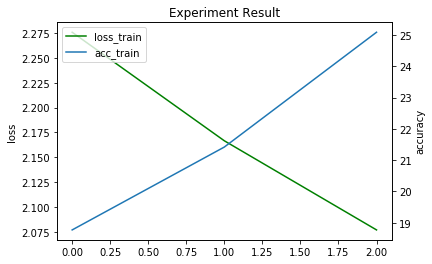

loss_train
[2.275811453819275, 2.1665634987354276, 2.0768699867725378]
acc_train
[18.77, 21.42, 25.09]


In [25]:
if args.federated_iid==True:
    do_federated_learning(mode='iid')

cifar10 FedAvg Non-iid(skew1class)로 학습


=> Creating model 'Conv2'
==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias
==> No gradient to fc3_global.weight
==> No gradient to fc3_global.bias
create new client data: False
This is global 0 epoch


main.ipynb:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "cell_type": "code",


 Average loss 0.184
Accuracy of the network on the 10000 test images: 11.590000 %
This is global 1 epoch
 Average loss 0.063
Accuracy of the network on the 10000 test images: 11.650000 %
This is global 2 epoch
 Average loss 0.063
Accuracy of the network on the 10000 test images: 10.000000 %


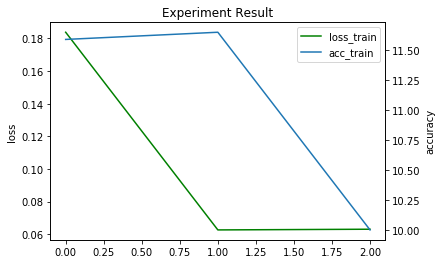

loss_train
[0.18381029382348063, 0.06265831878315656, 0.06308497688453645]
acc_train
[11.59, 11.65, 10.0]


In [26]:
if args.federated_skew1class==True:
    do_federated_learning(mode='skew1class')

cifar10 FedAvg Non-iid(dirichlet)로 학습

=> Creating model 'Conv2'
==> No gradient to conv1_global.weight
==> No gradient to conv1_global.bias
==> No gradient to conv2_global.weight
==> No gradient to conv2_global.bias
==> No gradient to fc1_global.weight
==> No gradient to fc1_global.bias
==> No gradient to fc2_global.weight
==> No gradient to fc2_global.bias
==> No gradient to fc3_global.weight
==> No gradient to fc3_global.bias
create new client data: False
This is global 0 epoch


main.ipynb:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "cell_type": "code",


 Average loss 1.622
Accuracy of the network on the 10000 test images: 10.650000 %
This is global 1 epoch
 Average loss 1.660
Accuracy of the network on the 10000 test images: 17.920000 %
This is global 2 epoch
 Average loss 1.582
Accuracy of the network on the 10000 test images: 20.030000 %


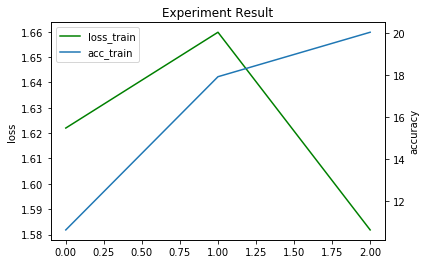

loss_train
[1.622007068297417, 1.6598083465216042, 1.5818086644216096]
acc_train
[10.65, 17.92, 20.03]


In [27]:
if args.federated_dirichlet==True:
    do_federated_learning(mode='dirichlet')